In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


- next meeting: 18, Monday 
- Kai's Job: 
    - X1.set missing to NaN 
    - X2. data cleansing- interpolation; moving average ; 
    - X3. sample class and function for each stage (outline)
    - X4. plots; 5. LSTM coding; 6. Adfuller iwth different IC;
    - 5. LSTM model construction (reframe)
    - X6. MAE/RMSE error evaluation
    - 7. Fine Tune framework
    - 8. How to train a model that accepts missing values?(https://machinelearningmastery.com/handle-missing-timesteps-sequence-prediction-problems-python/)
    - PS2. otehr possible imputation methods: KNN, stochastic regression
    - PS3. possible combination of LSTM and VAR model?
- Bennet's Job:
    - 1. data cleansing- timeoftheyear/ imputations 
    - 2. Get familiar with pandas and functions
    - 3. ac/pac/auto-corr-residual plots.
    - 4. R code for data preprocessing in the other kind of datasets (except Aquifer waterbody)
    - 5. record locations of missing values in original dataset(CSV).
    - 6. dump figures (png) 
    - PS. how to calculate rmse depnding on imputed values
    - PS2. data splitting ratio for train/validation/test: 8/1/1
    
    
- Together: 
    - 1. look up python package that help read R code inbody.
    - 2. VAR model (Rstudio/python)(adftest/ take differences/ cointegration check/ VAR_1stDiff|VAR_Ori|VECM model choice via (lag choice and coefs estimation)/ (adjusted-)portmanteau test /inference and performance.)

In [2]:
import os
for dirname, _, filenames, in os.walk('/Users/mbpr/Downloads/acea-water-prediction/'):
    for filename in filenames: 
        print(os.path.join(dirname, filename))

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date 
import math
import missingno as mnso

In [4]:
import tensorflow as tf
import keras
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.model_selection import TimeSeriesSplit

# Functions Plotting

In [5]:
def aquifer_feature_plots(df):
    """Plot each group of features of aquifer dataframe"""
    # create Date column
    if not 'Date' in df.columns.values:
        df['Date'] = df.index
    # plot Rainfalls
    sns.relplot(x='Date', y='value', col='Feature', col_wrap=5, kind='line', 
                data = df.filter(regex='Date|^Rainfall_.+').melt(
                        id_vars='Date', var_name='Feature', ignore_index=False))
    plt.suptitle('Rainfalls', y=1.02)
    # plot gounrdwaters and Volumes
    sns.relplot(x='Date', y='value', hue='Feature', kind='line', 
                data = df.filter(regex='Date|^Depth_.+').melt(
                        id_vars='Date', var_name='Feature', ignore_index=False))
    plt.suptitle('Groundwaters', y=1.02)
    sns.relplot(x='Date', y='value', hue='Feature', kind='line', 
                data = df.filter(regex='Date|^Volume_.+').melt(
                        id_vars='Date', var_name='Feature', ignore_index=False))
    plt.suptitle('Volumes', y=1.02)
    # plot Temperatures
    sns.relplot(x='Date', y='value', col='Feature', kind='line', 
                data = df.filter(regex='Date|^Temperature.+').melt(
                        id_vars='Date', var_name='Feature', ignore_index=False))
    plt.suptitle('Temperatures', y=1.02)
    # plot Hydrometry
    sns.relplot(x='Date', y='value', col='Feature', kind='line', 
                data = df.filter(regex='Date|^Hydrometry_.+').melt(
                        id_vars='Date', var_name='Feature', ignore_index=False))
    plt.suptitle('Hydrometries', y=1.02)
    plt.show()
    if 'Date' in df.columns.values:
        df.drop(columns='Date', inplace=True)

def missingval_plots(df):
    """
    Visualize index location of missin values of each feature.
    Doesn't work for 1-dim df.
    """
    # from matplotlib.colors import LinearSegmentedColormap
    # myColors = ((1.0, 1.0, 1.0, 1.0), (0.0, 0.0, 0.0, 1.0))
    # cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))
    g = sns.heatmap(df, cmap='Blues', cbar=True, yticklabels=df.index.values)
    # customize colorbar
    colorbar = g.collections[0].colorbar
    colorbar.set_ticks([0, 1])
    colorbar.set_ticklabels(['non-missing', 'missing'])
    # customize title
    ax.set_title('Distribution of Missing Values', fontsize=16)
    # customize font size in ticks
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(12) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(12)
    plt.show()

def rfft_plot(series):
    """plot real valued fourier transform to find most important frequency/periodicity"""
    fft = tf.signal.rfft(series)
    f_per_dataset = np.arange(0, len(fft))

    n_samples_d = len(series)
    d_per_year = 365.2524
    years_per_dataset = n_samples_d/(d_per_year)
    f_per_year = f_per_dataset/years_per_dataset

    plt.step(f_per_year, np.abs(fft))
    plt.xscale('log')
    plt.ylim(0, 400)
    plt.xlim([0.1, max(plt.xlim())])
    plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
    _ = plt.xlabel('Frequency (log scale)')
    plt.show()

# Data Preprocessing

In [6]:
def fillna(data, approach, **kwargs):
    """fill nan with the specified approach."""
    if approach == 'constant':
        return data.fillna(-99999)
    elif approach == 'mean':
        return data.fillna(data.mean(axis=0, skipna=True))
    elif approach == 'median': 
        return data.fillna(data.median(axis=0, skipna=True))
    elif approach == 'interpolate':
        # data cannot contain datetime columns
        # kwargs: method, axis, limit, limit_direction, limit_area, inplace
        return data.interpolate(**kwargs)
    elif approach == 'movingavg':
        # kwargs: window, min_periods, center, win_type
        return data.fillna(data.rolling(**kwargs).mean())
    elif approach == 'regression':
        pass 
    elif approach == 'stochasticreg':
        pass
    elif approach == 'KNN':
        pass
    elif approach == 'LDA':
        pass
    else:
        raise ValueError('Keyword not found for approach')

def adftest(series, verbose=1, **kwargs):
    """adfuller + printing"""
    # kwargs: maxlag, regression, autolag
    from statsmodels.tsa.stattools import adfuller
    res = adfuller(series.values, **kwargs)
    if verbose:
        print('ADF Statistic: {:13f} \tp-value: {:10f}'.format(res[0], res[1]))
        if 'autolag' in kwargs.keys():
            print('IC: {:6s} \t\t\tbest_lag: {:9d}'.format(kwargs['autolag'], res[2]))
        print('Critical Values: ', end='')
        for key, value in res[4].items():
            print('{:2s}: {:>7.3f}\t'.format(key, value), end='')
    return res

# Feature Engineering

In [7]:
def shift_concat(df, lag=1, dropna=True):
    """
    shift df from from 0 till lag, then concat all dfs together and return.
    Arguments:
        df: pd.DataFrame format dataset.
        lag>0: Number of lag observations as input (X).
        dropnan: Boolean whether or not to drop rows with NaN values.
    """
    col_name = df.columns.values
    collector = []
    for i in range(lag, 0, -1):
        tmp = df.shift(i)
        tmp.columns = col_name + '(-{:s})'.format(str(i))
        collector.append(tmp)
    collector.append(df)
    df = pd.concat(collector, axis=1)
    if dropna:
        df.dropna(inplace=True)
    return df

def invert_diff(df_before_yhat, yhat, n_diff=1):
    """Recover corresponding value of prediction in differenced feature back to the one before diff()."""    
    try: 
        axis = 1 if df_before_yhat.shape[1] > 1 else 0
    except:
        axis = 0 
    if type(df_before_yhat) != np.ndarray:
        df_before_yhat = df_before_yhat.values
    array = np.concatenate((df_before_yhat, yhat), axis=0)

    for d in range(0, n_diff):
        array = array.cumsum(axis=axis)
    return array

def scale(train, val, test, approach='MinMax'):
    """scale train (and test) data via MinMaxScalar/StandardScalar"""
    if approach == 'MinMax':
        scaler = MinMaxScaler(feature_range=(-1, 1))
    elif approach == 'Standard':
        scaler == StandardScaler()
    # save DataFrame Info
    # fit and transform train
    scaler = scaler.fit(train)
    train_scaled = pd.DataFrame(scaler.transform(train), columns=train.columns, index=train.index)
    # transform val/test
    val_scaled = pd.DataFrame(scaler.transform(val), columns=val.columns, index=val.index)
    test_scaled = pd.DataFrame(scaler.transform(test), columns=test.columns, index=test.index)
    return scaler, train_scaled, val_scaled, test_scaled


In [349]:
class WindowGenerator:
    """
    Initialize a window generator that helps slice train/val/test_df into inputs and labels.
    Explanation for input_width, label_width, shift and total_window_size:
        Given inputs of size (batch, input_width, n_features), we wish to train a model that 
        its output shape is equivalent to the labels shape (batch, labels_width, n_features)
        which has a timestep gap = shift. total_window_size = input_width+shift.
    Eg, w=WindowGenerator(input_width=2, label_width=1, shift=1, ...)
        Given past 2 hrs, predict the target values in the next hr. (total window is 3)
    Eg, w=WindowGenerator(input_width=2, label_width=1, shift=2, ...)
        Given past 2 hrs, predict the result values in the 2nd hr. (total window is 4)
    Eg, w=WindowGenerator(input_width=2, label_width=2, shift=2, ...)
        Given past 2 hrs, predict the result values in next 2 hrs. (total window is 4)
    """
    def __init__(self, input_width, label_width, shift, batch_size=32,
                 train_df=train_scaled, val_df=val_scaled, test_df=test_scaled, label_columns=None):
        # Store the raw data. [batch_size, timestep, features]
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.batch_size = batch_size

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width) #slice from idx=0 till idx=input_width-1(included)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None) # slice from idx=label_start wihout end
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        """
        Split data into inputs and labels.
        features: [batch=None, self.total_window_size, features=None]
        """
        inputs = features[:, self.input_slice, :]
        # return all features if self.label_columns is None
        # Ow, return only featrues in self.label_columns in order
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)
        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col='Depth_to_Groundwater_SAL', max_subplots=3, figsize=(15, 10)):
        inputs, labels = self.example # [batch_size, timestep, features]
        plt.figure(figsize=figsize, )
        if type(plot_col) is str: 
            plot_col = [plot_col]
        plot_col_index = [self.column_indices[col] for col in plot_col]
        
        max_n = min(max_subplots, len(inputs)) # arg vs batch_size
        max_j = len(plot_col)
        for n in range(max_n):
            for j in range(max_j):
                fig = plt.subplot(max_n, max_j, max_j*n + j+1)
                fig.figure.tight_layout(pad=1.0)
                # plot plot_col[j] as Inputs
                plt.title(f'y:{plot_col[j]} [scaled]')
                plt.plot(self.input_indices, inputs[n, :, plot_col_index[j]],
                         label='Inputs', marker='.', zorder=-10)
                # plot Ground truth of plot_col[j] == labels[label_col_index] (same string)
                if self.label_columns:
                    label_col_index = self.label_columns_indices.get(plot_col[j], None)
                else:
                    label_col_index = plot_col_index[j]
                if label_col_index is None:
                    continue
                    
                plt.scatter(self.label_indices, labels[n, :, label_col_index], 
                            edgecolors='k', label='Labels', c='#2ca02c', s=64)
                # plot prediction of plot_col[j]
                if model is not None:
                    predictions = model(inputs)
                    plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                              marker='X', edgecolors='k', label='Predictions',
                              c='#ff7f0e', s=64)
                if n == 0:
                    plt.legend()
                plt.xlabel(f'Sample {n} in batch.  Timestep [scaled]')

    def make_dataset(self, data):
        """convert df/data to tf.data.Dataset of (inputs, labels) pairs"""
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=self.batch_size,)
        
        ds = ds.map(self.split_window)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result


# Model Classes

In [8]:
# TODO: 3 Possible models: VECM model | VAR_original model | VAR_stationary model
class VAR:
    
    def __init__(self):
        pass 

# TODO: Sequence Prediction(aka One-step TS Forecasting) | Sequence-to-Sequence Prediction(aka Multi-step TS Forecasting)
# with one/three groundwater output(s) at a time.
# Note: the random initial conditions for an LSTM network can result in very different performance each time a 
# given configuration is trained.




# Main Code

## Aquifer: Auser
There are 5 different kinds of Depth_to_Groundwater_* variables, where SAL, PAG, CoS, DIEC stand for north systems and LT2 stands for south system. (south system is partially affected by the north ones).
The goal is to predict SAL, COS, and LT2.

In [9]:
dataset = 'Aquifer_Auser.csv'

# read dataset as DataFrame
dateparse = lambda x: datetime.strptime(x, '%d/%m/%Y')
#df = pd.read_csv("/kaggle/input/acea-water-prediction/"+dataset, index_col='Date', parse_dates=['Date'], date_parser=dateparse))
df = pd.read_csv("./data/"+dataset, index_col='Date', parse_dates=['Date'], date_parser=dateparse)
df.index.freq = 'd'
df.sort_index(inplace=True)

display(df)

,Rainfall_Gallicano,Rainfall_Pontetetto,Rainfall_Monte_Serra,Rainfall_Orentano,Rainfall_Borgo_a_Mozzano,Rainfall_Piaggione,Rainfall_Calavorno,Rainfall_Croce_Arcana,Rainfall_Tereglio_Coreglia_Antelminelli,Rainfall_Fabbriche_di_Vallico,...,Temperature_Monte_Serra,Temperature_Ponte_a_Moriano,Temperature_Lucca_Orto_Botanico,Volume_POL,Volume_CC1,Volume_CC2,Volume_CSA,Volume_CSAL,Hydrometry_Monte_S_Quirico,Hydrometry_Piaggione
Date,,,,,,,,,,,,,,,,,,,,,
1998-03-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-03-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.0,10.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-03-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.20,0.0,10.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-03-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.40,0.0,13.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-03-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.40,0.0,12.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,20.75,0.0,23.75,-7189.406533,-7847.900,-9183.433333,-6115.40,-3158.0,0.20,-1.03
2020-06-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,21.35,0.0,24.30,-7189.406533,-7847.900,-9183.433333,-6115.40,-3158.0,0.21,-1.03
2020-06-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,21.75,0.0,24.55,-6829.936207,-7455.505,-8724.261667,-5809.63,-3000.1,0.23,-1.03


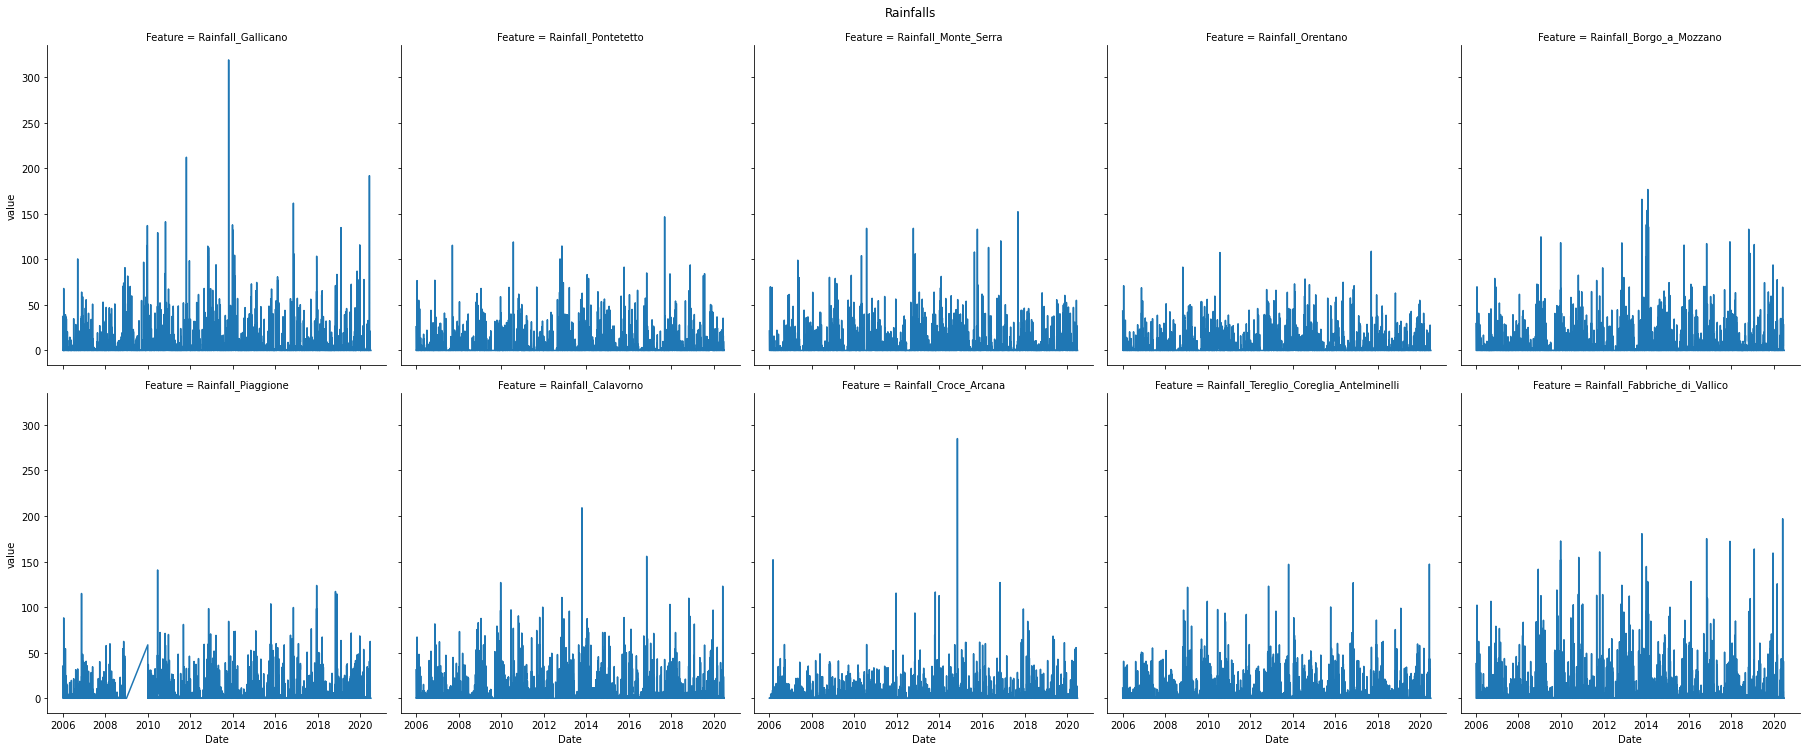

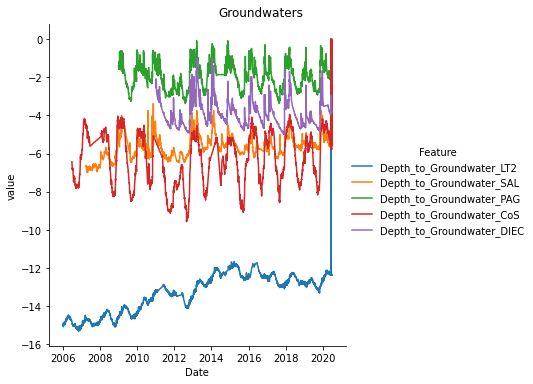

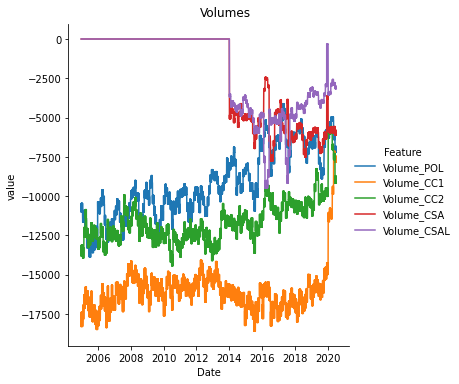

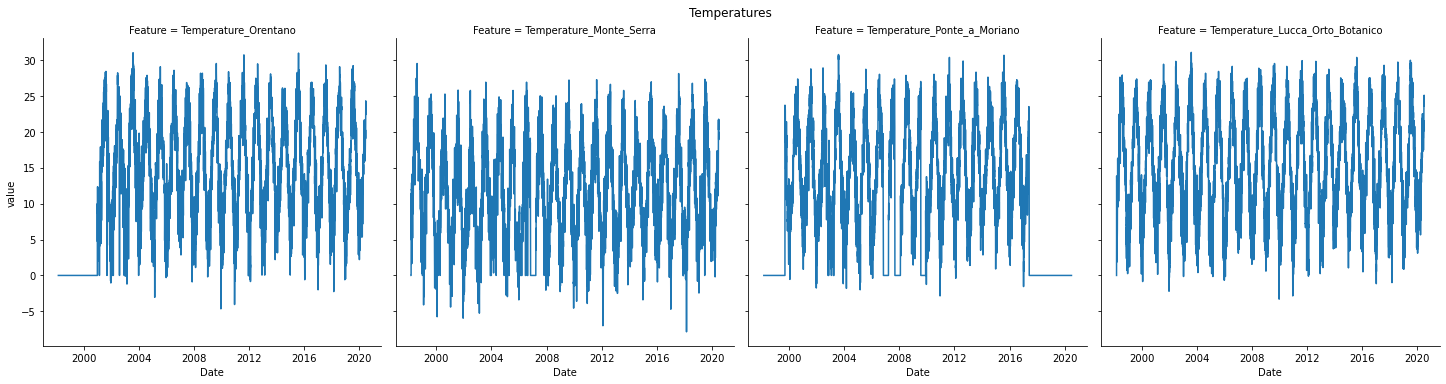

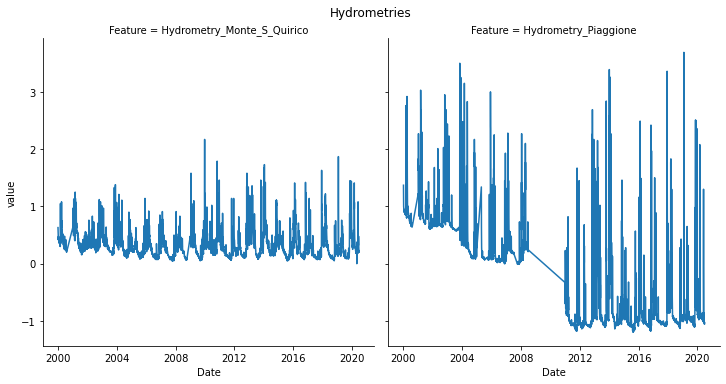

In [10]:
# basic plot of each feature
aquifer_feature_plots(df)

In [11]:
# basic plot of correlation between features


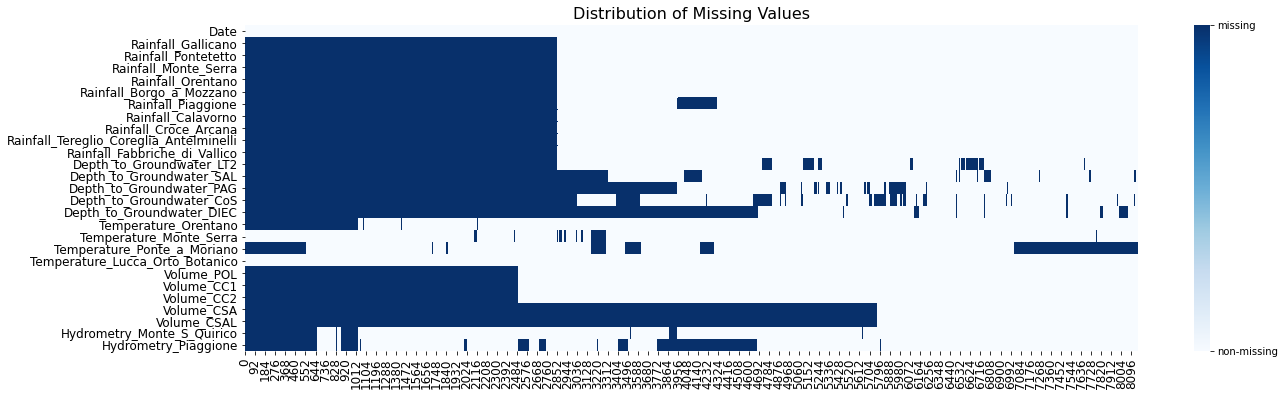

In [12]:
# Set weird values to nan
## set nan to Groundwater whose values are 0
df[df.filter(regex='Depth_*').columns] = df.filter(regex='Depth_*').replace(0, np.nan)
## set nan to Volume whose values are 0
df[df.filter(regex='Volume_*').columns] = df.filter(regex='Volume_*').replace(0, np.nan)
## set nan to Temperature whose values are 0
df[df.filter(regex='Temperature_*').columns] = df.filter(regex='Temperature_*').replace(0, np.nan)

# visual graph of nan locations for each field
missingval_plots(df.reset_index().T.isna())

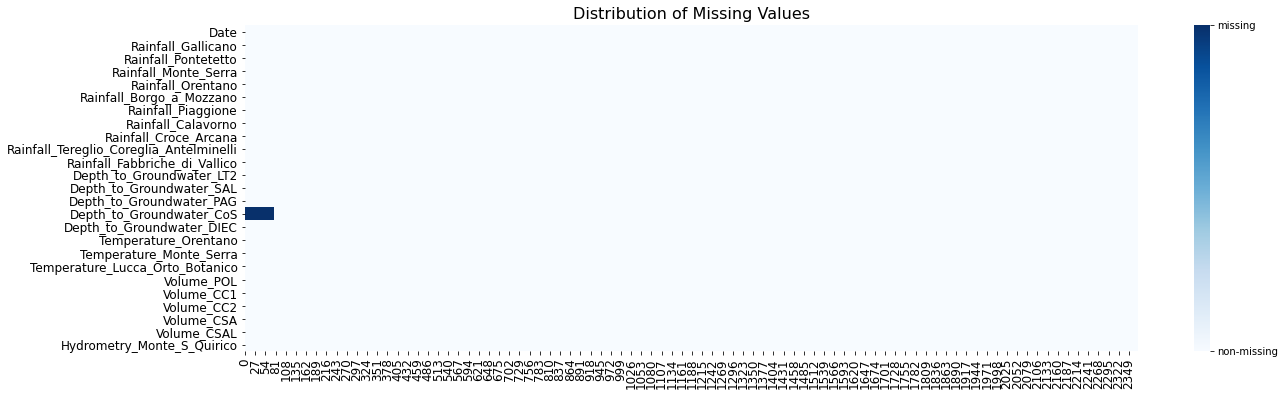

In [13]:
# Dealing with missing values

## drop old/unuseful data
todrop = df[df.Volume_CSA.isna()].index.max()
df = df[df.index > todrop].copy() # remaining data starts from 2014-01-01
## drop columns (to be further confirmed)
df.drop(columns=['Temperature_Ponte_a_Moriano', 'Hydrometry_Piaggione'], inplace=True)

## Record nan positions before imputation
#mask = df.isna()

## imputation
#nondate_cols = dfsmall.iloc[:, 2:-9].columns
dfimputed = df.copy()
tmp = fillna(dfimputed, 'interpolate', method='linear').copy()
dfimputed= tmp

## visual graph of nan locations 
missingval_plots(dfimputed.reset_index().T.isna())


In [14]:
todrop = dfimputed[dfimputed['Depth_to_Groundwater_CoS'].isna()].index.max()
dfimputed = dfimputed[dfimputed.index > todrop].copy()
assert dfimputed.isna().any().any() == False

#aquifer_feature_plots(dfimputed)

(2295, 24)


In [15]:
# Make it stationary: seasonality can be eliminated by using diff() or deducting a a seasonal pattern found by seasonal_decompose
## adftest
adftable = pd.DataFrame(columns=['AIC_5%level', 'AIC_bestlag', 'BIC_5%level', 'BIC_bestlag'])
for col in dfimputed.columns:
    row = []
    for autolag in ['AIC', 'BIC']:
        res = adftest(dfimputed[col], verbose=0, maxlag=30, regression='ct', autolag=autolag)
        sig = True if abs(res[0])>abs(res[4]['5%']) else False
        row.extend([sig, res[2]])
    adftable = adftable.append(pd.Series(row, index=adftable.columns, name=col))

display(adftable)

,AIC_5%level,AIC_bestlag,BIC_5%level,BIC_bestlag
Rainfall_Gallicano,True,18,True,0
Rainfall_Pontetetto,True,11,True,0
Rainfall_Monte_Serra,True,13,True,0
Rainfall_Orentano,True,20,True,0
Rainfall_Borgo_a_Mozzano,True,12,True,0
Rainfall_Piaggione,True,12,True,0
Rainfall_Calavorno,True,18,True,2
Rainfall_Croce_Arcana,True,0,True,0
Rainfall_Tereglio_Coreglia_Antelminelli,True,11,True,3
Rainfall_Fabbriche_di_Vallico,True,14,True,2


In [16]:
## (Cont'd) diff() on cols that do not pass the adftest. Here we adopt AIC.
dfstationary = dfimputed.copy()
I1 = adftable[adftable['AIC_5%level'] == False].index.values
dfstationary.loc[:,I1] = dfstationary[I1].diff()
dfstationary.dropna(inplace=True)

## adftest again
adftable = pd.DataFrame(columns=['AIC_5%level', 'AIC_bestlag', 'BIC_5%level', 'BIC_bestlag'])
for col in dfstationary.columns:
    row = []
    for autolag in ['AIC', 'BIC']:
        res = adftest(dfstationary[col], verbose=0, maxlag=30, regression='ct', autolag=autolag)
        sig = True if abs(res[0])>abs(res[4]['5%']) else False
        row.extend([sig, res[2]])
    adftable = adftable.append(pd.Series(row, index=adftable.columns, name=col))

display(adftable) # This time all features pass ADF test in both AIC and BIC criteria.

,AIC_5%level,AIC_bestlag,BIC_5%level,BIC_bestlag
Rainfall_Gallicano,True,18,True,0
Rainfall_Pontetetto,True,11,True,0
Rainfall_Monte_Serra,True,13,True,0
Rainfall_Orentano,True,20,True,0
Rainfall_Borgo_a_Mozzano,True,12,True,0
Rainfall_Piaggione,True,12,True,0
Rainfall_Calavorno,True,18,True,2
Rainfall_Croce_Arcana,True,0,True,0
Rainfall_Tereglio_Coreglia_Antelminelli,True,11,True,3
Rainfall_Fabbriche_di_Vallico,True,14,True,2


In [17]:
# more feature engineering... to be continued
# Eg, dimension reduction: PCA, LDA; Granger Causality, Cointegration
#     denoicing: FFT/STFT, MovingAvg, 

In [18]:
# deal with Time Periodicity 
## extract year, month, quarter, day etc from Date (to be further confirmed)
# nondate_cols = dfstationary.columns
# dfstationary['year'] = dfstationary.index.year
# dfstationary['month'] = dfstationary.index.month
# dfstationary['day'] = dfstationary.index.day
# dfstationary['day_of_year'] = dfstationary.index.dayofyear
# dfstationary['week_of_year'] = dfstationary.index.isocalendar().week
# dfstationary['quarter'] = dfstationary.index.quarter
# dfstationary['year_quarter'] = dfstationary.index.to_period('q')
## yearly base periodicity
year = 365.2425
dfstationary['year_sin'] = np.sin(dfstationary.index.dayofyear * 2 * np.pi / year)
dfstationary['year_cos'] = np.cos(dfstationary.index.dayofyear * 2 * np.pi / year)

In [31]:
# Put target columns at the end
targets = ['Depth_to_Groundwater_SAL', 'Depth_to_Groundwater_CoS', 'Depth_to_Groundwater_LT2']
timestep = 2
n_features = dfstationary.shape[1]
# dfstationary = dfstationary.reindex(columns = dfstationary.columns.drop(labels).append(pd.Index(labels)), )

# Transform the format from TS to the one for supervised learning.
# dfsupervise = shift_concat(dfstationary, lag=lag)
# display(dfsupervise)

In [127]:
# Splitting data: keep the last ca. 365 data for prediction
# Alternative splitting:
# N = dfsupervise.shape[0]
# train, val, test = dfsupervise[:int(0.8*N)], dfsupervise[int(0.8*N):int(0.9*N)], dfsupervise[int(0.9*N):]
column_indices = {name: i for i, name in enumerate(dfstationary.columns)}
tmp = dfstationary[dfstationary.index < '2019-07-01']
test = dfstationary[dfstationary.index >= '2019-07-01']
train, val = tmp[:int(0.8*len(tmp))], tmp[int(0.8*len(tmp)):]


# Scaling and Normalization 
# normalization won't make sense if the TS is trending upward/downward. This is why stationary first.
scaler, train_scaled, val_scaled, test_scaled = scale(train, val, test, approach='MinMax')
print(train_scaled.shape, val_scaled.shape, test_scaled.shape)
# train_scaled = train_scaled.reshape([])
# val_scaled = val_scaled.reshape([])
# test_scaled = test_scaled.reshape([])

# data further splitting
# nonlabels = dfsupervise.columns[~dfsupervise.columns.isin(labels)]
# X_train, y_train = train_scaled[nonlabels], train_scaled[labels]
# X_val, y_val = val_scaled[nonlabels], val_scaled[labels]
# X_test, y_test = test_scaled[nonlabels], test_scaled[labels]


# # transform to (batch, timestep, features) shape required by tensorflow: np.ndarray type
# Xshape, yshape = (-1, timestep, n_features), (-1, 1, len(labels))
# X_train, y_train = X_train.values.reshape(*Xshape), y_train.values.reshape(*yshape)
# X_val, y_val = X_val.values.reshape(*Xshape), y_val.values.reshape(*yshape)
# X_test, y_test = X_test.values.reshape(*Xshape), y_test.values.reshape(*yshape)
# print('Shapes: X_train{}, y_train{}, X_val{}, y_val{}, X_test{}, y_test{}'.format(
#     X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape
# ))


(1542, 26) (386, 26) (366, 26)


In [378]:
w = WindowGenerator(input_width=2, label_width=1, shift=1, label_columns=targets)
print(w)

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

Total window size: 3
Input indices: [0 1]
Label indices: [2]
Label column name(s): ['Depth_to_Groundwater_SAL', 'Depth_to_Groundwater_CoS', 'Depth_to_Groundwater_LT2']


Xtrain shape:  (32, 2, 26) ytrain shape:  (32, 1, 3)
output shape:  (32, 1, 3)
12/12 - 0s - loss: 0.0206 - mean_absolute_error: 0.0752 - mean_squared_error: 0.0206
12/12 - 0s - loss: 0.0314 - mean_absolute_error: 0.0932 - mean_squared_error: 0.0314


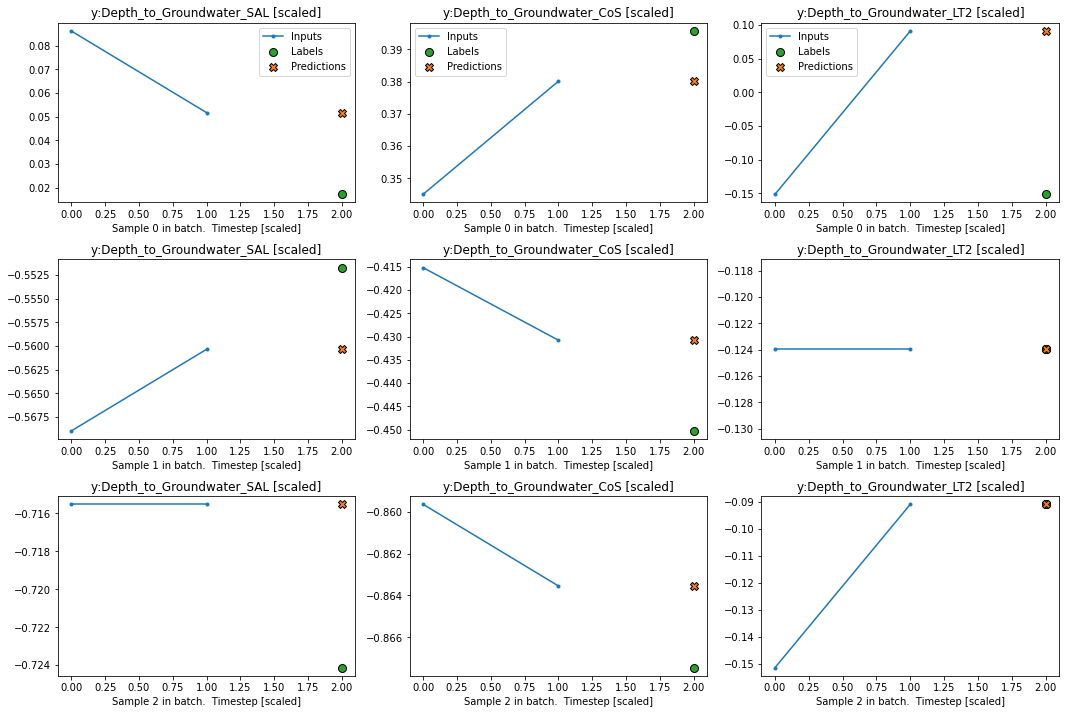

In [325]:
# naive baseline yt+1 = yt
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = tf.stack( [inputs[:, -1, j] for j in self.label_index] ,  axis=1)
        return result[:, tf.newaxis, :]

baseline = Baseline(label_index=[column_indices[ta] for ta in targets])
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError()])

print('Xtrain shape: ', w.example[0].shape, 'ytrain shape: ', w.example[1].shape)
print('output shape: ', baseline(w.example[0]).shape)

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(w.val, verbose=2)
performance['Baseline'] = baseline.evaluate(w.test, verbose=2) 
w.plot(baseline, targets)

Xtrain shape:  (32, 2, 26) ytrain shape:  (32, 1, 3)
output shape:  (32, 1, 3)
Epoch 1/20
49/49 [==============================] - 1s 7ms/step - loss: 0.1264 - mean_absolute_error: 0.2518 - mean_squared_error: 0.1264 - val_loss: 0.0371 - val_mean_absolute_error: 0.1520 - val_mean_squared_error: 0.0371
Epoch 2/20
49/49 [==============================] - 0s 5ms/step - loss: 0.0269 - mean_absolute_error: 0.1208 - mean_squared_error: 0.0269 - val_loss: 0.0357 - val_mean_absolute_error: 0.1474 - val_mean_squared_error: 0.0357
Epoch 3/20
49/49 [==============================] - 0s 4ms/step - loss: 0.0211 - mean_absolute_error: 0.1043 - mean_squared_error: 0.0211 - val_loss: 0.0348 - val_mean_absolute_error: 0.1443 - val_mean_squared_error: 0.0348
Epoch 4/20
49/49 [==============================] - 0s 4ms/step - loss: 0.0187 - mean_absolute_error: 0.0951 - mean_squared_error: 0.0187 - val_loss: 0.0298 - val_mean_absolute_error: 0.1332 - val_mean_squared_error: 0.0298
Epoch 5/20
49/49 [=======

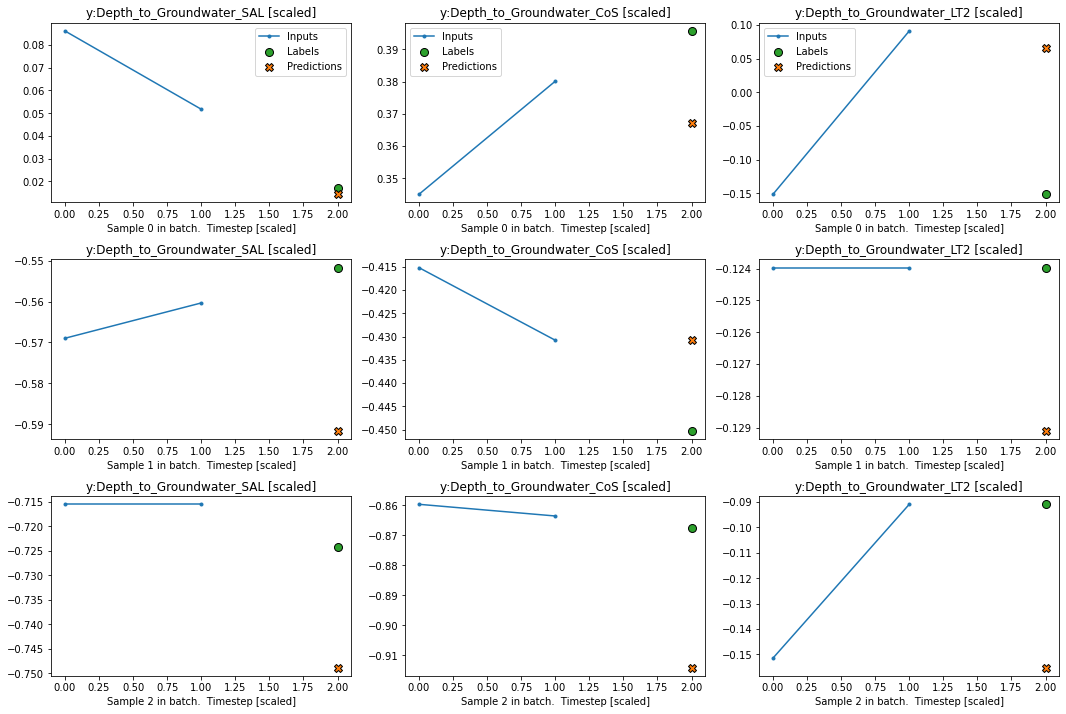

In [326]:
# CNN many-to-one
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    #tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(units=32, activation='relu'),
    
    # alternatively, tf.keras.layers.Conv1D(filters=32, kernel_size=(CONV_WIDTH,),activation='relu')
    # and reshape can be withdrawn.
    tf.keras.layers.Conv1D(filters=32, kernel_size=(2,),activation='relu'),
    
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=3),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    # tf.keras.layers.Reshape([1, -1]),
])
MAX_EPOCHS = 20
print('Xtrain shape: ', w.example[0].shape, 'ytrain shape: ', w.example[1].shape)
print('output shape: ', multi_step_dense(w.example[0]).shape)

history = compile_and_fit(multi_step_dense, w)

val_performance['MultistepDense_nto1'] = multi_step_dense.evaluate(w.val, verbose=2)
performance['MultistepDense_nto1'] = multi_step_dense.evaluate(w.test, verbose=2)
w.plot(multi_step_dense, targets)

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Depth_to_Groundwater_SAL', 'Depth_to_Groundwater_CoS', 'Depth_to_Groundwater_LT2']
Xtrain shape:  (32, 24, 26) ytrain shape:  (32, 23, 3)
output shape:  (32, 23, 3)
Epoch 1/20
48/48 [==============================] - 1s 7ms/step - loss: 0.0103 - mean_absolute_error: 0.0628 - mean_squared_error: 0.0103 - val_loss: 0.0162 - val_mean_absolute_error: 0.0918 - val_mean_squared_error: 0.0162
Epoch 2/20
48/48 [==============================] - 0s 5ms/step - loss: 0.0098 - mean_absolute_error: 0.0592 - mean_squared_error: 0.0098 - val_loss: 0.0156 - val_mean_absolute_error: 0.0900 - val_mean_squared_error: 0.0156
Epoch 3/20
48/48 [==============================] - 0s 5ms/step - loss: 0.0094 - mean_absolute_error: 0.0578 - mean_squared_error: 0.0094 - val_loss: 0.0149 - val_mea

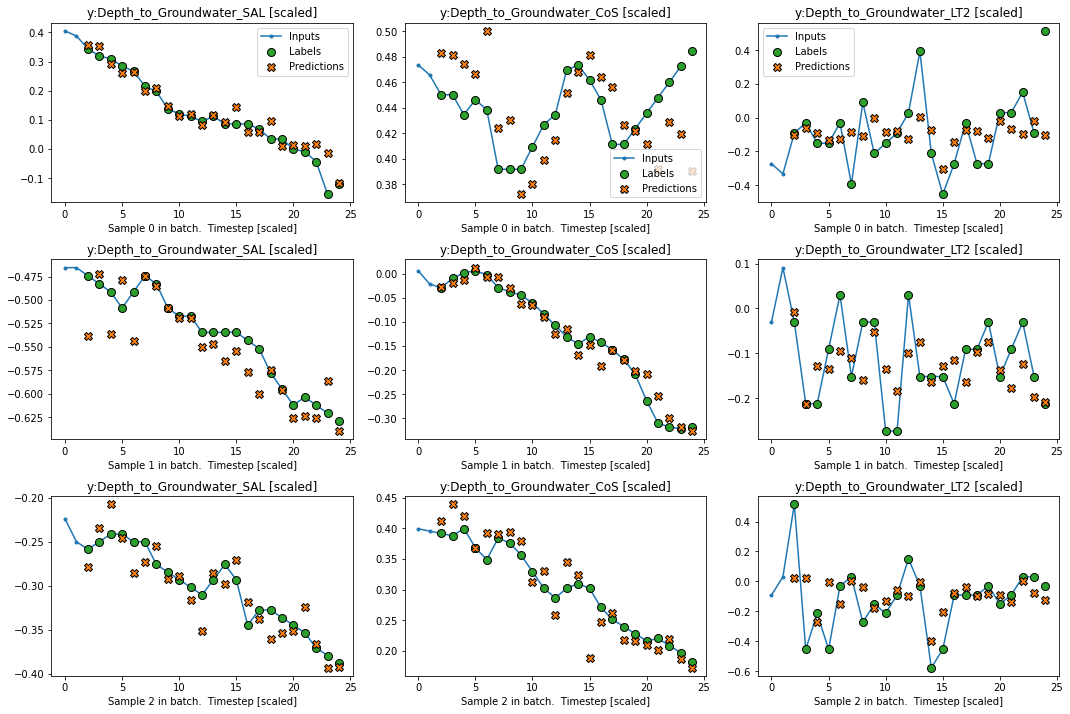

In [327]:
# CNN many-to-many: every 2days input for the next day prediction
wide_w = WindowGenerator(input_width=24, label_width=23, shift=1, label_columns=targets)
print(wide_w)

MAX_EPOCHS = 20
print('Xtrain shape: ', wide_w.example[0].shape, 'ytrain shape: ', wide_w.example[1].shape)
print('output shape: ', multi_step_dense(wide_w.example[0]).shape)

history = compile_and_fit(multi_step_dense, wide_w)
val_performance['MultistepDense_2to1'] = multi_step_dense.evaluate(wide_w.val, verbose=2)
performance['MultistepDense_2to1'] = multi_step_dense.evaluate(wide_w.test, verbose=2)
wide_w.plot(multi_step_dense, targets)


Xtrain shape:  (32, 2, 26) ytrain shape:  (32, 1, 3)
output shape:  (32, 1, 3)
Epoch 1/20
49/49 [==============================] - 2s 14ms/step - loss: 0.1569 - mean_absolute_error: 0.3048 - mean_squared_error: 0.1569 - val_loss: 0.0384 - val_mean_absolute_error: 0.1494 - val_mean_squared_error: 0.0384
Epoch 2/20
49/49 [==============================] - 0s 6ms/step - loss: 0.0339 - mean_absolute_error: 0.1346 - mean_squared_error: 0.0339 - val_loss: 0.0362 - val_mean_absolute_error: 0.1487 - val_mean_squared_error: 0.0362
Epoch 3/20
49/49 [==============================] - 0s 5ms/step - loss: 0.0214 - mean_absolute_error: 0.1022 - mean_squared_error: 0.0214 - val_loss: 0.0331 - val_mean_absolute_error: 0.1343 - val_mean_squared_error: 0.0331
Epoch 4/20
49/49 [==============================] - 0s 6ms/step - loss: 0.0175 - mean_absolute_error: 0.0887 - mean_squared_error: 0.0175 - val_loss: 0.0329 - val_mean_absolute_error: 0.1330 - val_mean_squared_error: 0.0329
Epoch 5/20
49/49 [======

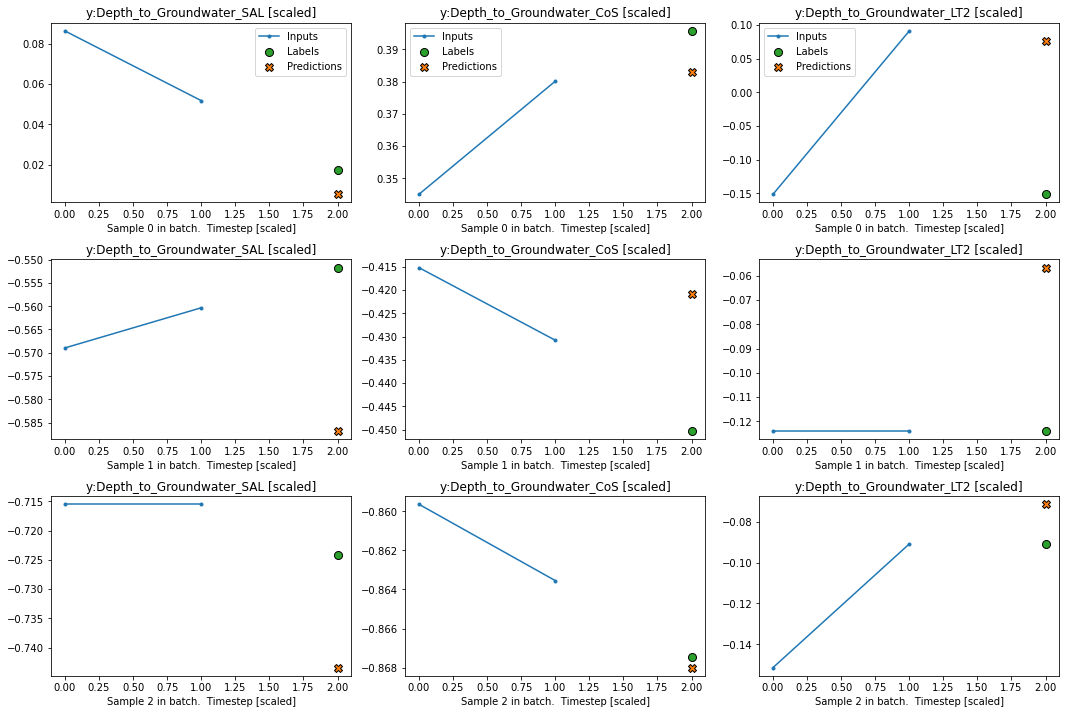

In [328]:
# RNN many-to-one
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=3), 
    tf.keras.layers.Reshape([1, -1])
])

MAX_EPOCHS = 20
print('Xtrain shape: ', w.example[0].shape, 'ytrain shape: ', w.example[1].shape)
print('output shape: ', lstm_model(w.example[0]).shape)


history = compile_and_fit(lstm_model, w)
val_performance['lstm_nto1'] = lstm_model.evaluate(w.val, verbose=2)
performance['lstm_nto1'] = lstm_model.evaluate(w.test, verbose=2)
w.plot(lstm_model, targets)


Baseline    : 0.0932
MultistepDense_nto1: 0.1377
MultistepDense_nton: 0.1547
lstm_nto1   : 0.0987


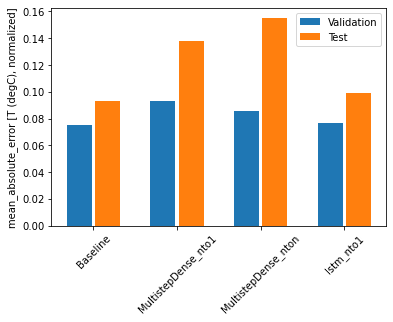

In [329]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

Total window size: 14
Input indices: [0 1 2 3 4 5 6]
Label indices: [ 7  8  9 10 11 12 13]
Label column name(s): None


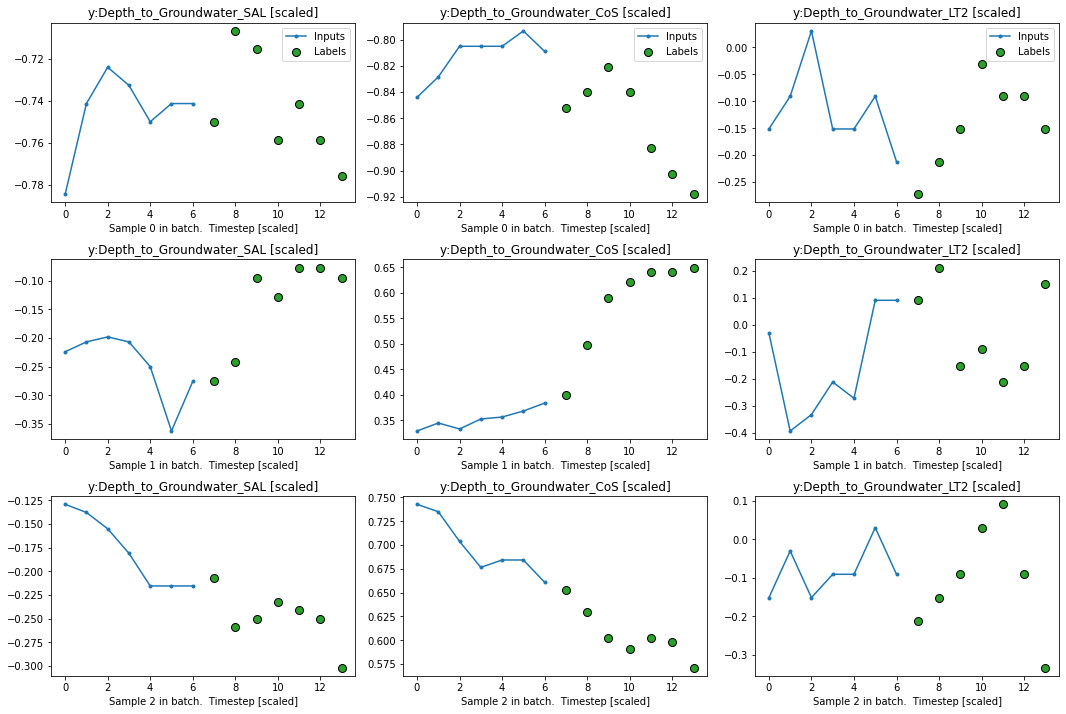

In [351]:
# # RNN many-to-many but predict difference (residual)
OUT_STEPS = 7
multi_window = WindowGenerator(input_width=7,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS, 
                               )
print(multi_window)
multi_window.plot(plot_col= targets)



12/12 - 0s - loss: 0.0391 - mean_absolute_error: 0.0961 - mean_squared_error: 0.0391
12/12 - 0s - loss: 0.0537 - mean_absolute_error: 0.1187 - mean_squared_error: 0.0537


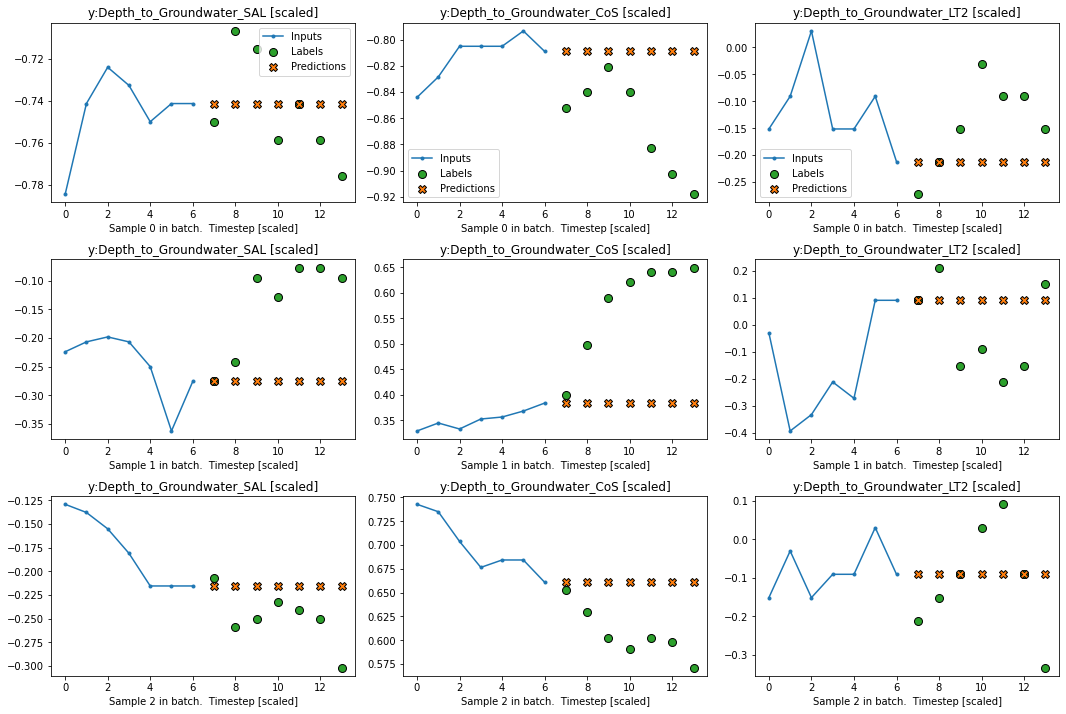

In [358]:
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val, verbose=2)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=2)
multi_window.plot(last_baseline, targets)

12/12 - 0s - loss: 0.0363 - mean_absolute_error: 0.0920 - mean_squared_error: 0.0363
12/12 - 0s - loss: 0.0535 - mean_absolute_error: 0.1156 - mean_squared_error: 0.0535


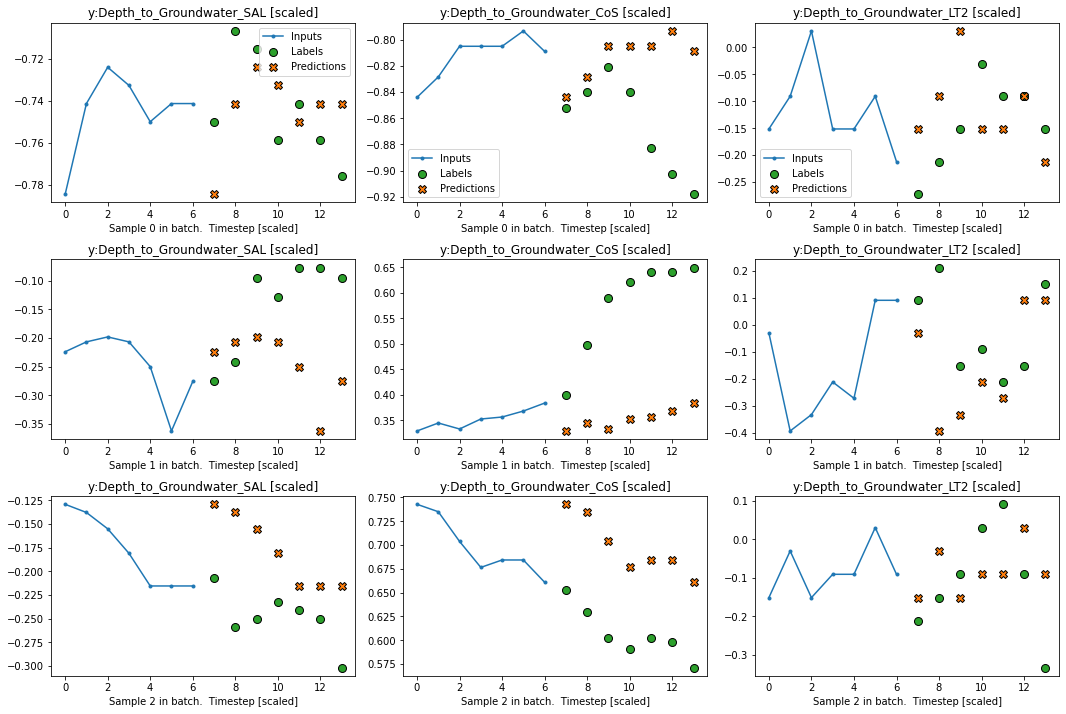

In [357]:
class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val, verbose=2)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=2)
multi_window.plot(repeat_baseline, targets)

Epoch 1/20
48/48 [==============================] - 1s 8ms/step - loss: 0.2067 - mean_absolute_error: 0.3386 - mean_squared_error: 0.2067 - val_loss: 0.0456 - val_mean_absolute_error: 0.1440 - val_mean_squared_error: 0.0456
Epoch 2/20
48/48 [==============================] - 0s 5ms/step - loss: 0.0322 - mean_absolute_error: 0.1147 - mean_squared_error: 0.0322 - val_loss: 0.0309 - val_mean_absolute_error: 0.1114 - val_mean_squared_error: 0.0309
Epoch 3/20
48/48 [==============================] - 0s 5ms/step - loss: 0.0270 - mean_absolute_error: 0.0992 - mean_squared_error: 0.0270 - val_loss: 0.0285 - val_mean_absolute_error: 0.1075 - val_mean_squared_error: 0.0285
Epoch 4/20
48/48 [==============================] - 0s 4ms/step - loss: 0.0251 - mean_absolute_error: 0.0946 - mean_squared_error: 0.0251 - val_loss: 0.0265 - val_mean_absolute_error: 0.1053 - val_mean_squared_error: 0.0265
Epoch 5/20
48/48 [==============================] - 0s 4ms/step - loss: 0.0242 - mean_absolute_error: 0.

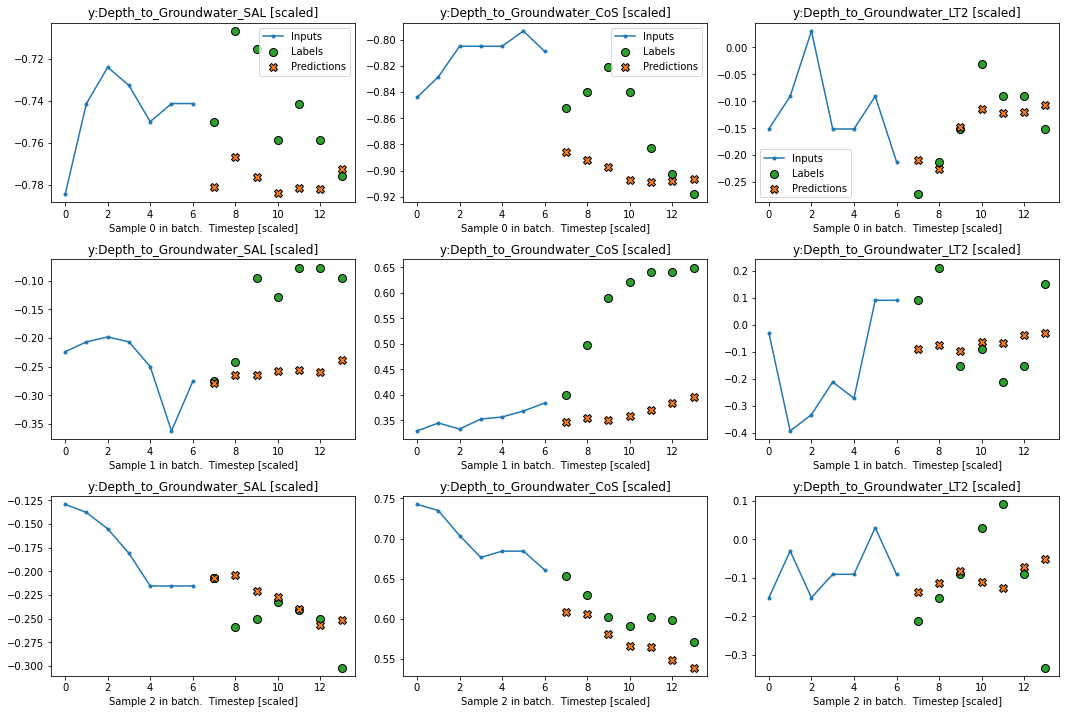

In [365]:
CONV_WIDTH = 7
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*26, #n_features
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, 26])
])

history = compile_and_fit(multi_conv_model, multi_window)

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val, verbose=2)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=2)
multi_window.plot(multi_conv_model, targets)

Epoch 1/20
48/48 [==============================] - 2s 15ms/step - loss: 0.3635 - mean_absolute_error: 0.4939 - mean_squared_error: 0.3635 - val_loss: 0.1033 - val_mean_absolute_error: 0.2087 - val_mean_squared_error: 0.1033
Epoch 2/20
48/48 [==============================] - 0s 7ms/step - loss: 0.0947 - mean_absolute_error: 0.2002 - mean_squared_error: 0.0947 - val_loss: 0.0816 - val_mean_absolute_error: 0.1890 - val_mean_squared_error: 0.0816
Epoch 3/20
48/48 [==============================] - 0s 7ms/step - loss: 0.0735 - mean_absolute_error: 0.1746 - mean_squared_error: 0.0735 - val_loss: 0.0759 - val_mean_absolute_error: 0.1789 - val_mean_squared_error: 0.0759
Epoch 4/20
48/48 [==============================] - 0s 7ms/step - loss: 0.0619 - mean_absolute_error: 0.1612 - mean_squared_error: 0.0619 - val_loss: 0.0666 - val_mean_absolute_error: 0.1709 - val_mean_squared_error: 0.0666
Epoch 5/20
48/48 [==============================] - 0s 7ms/step - loss: 0.0541 - mean_absolute_error: 0

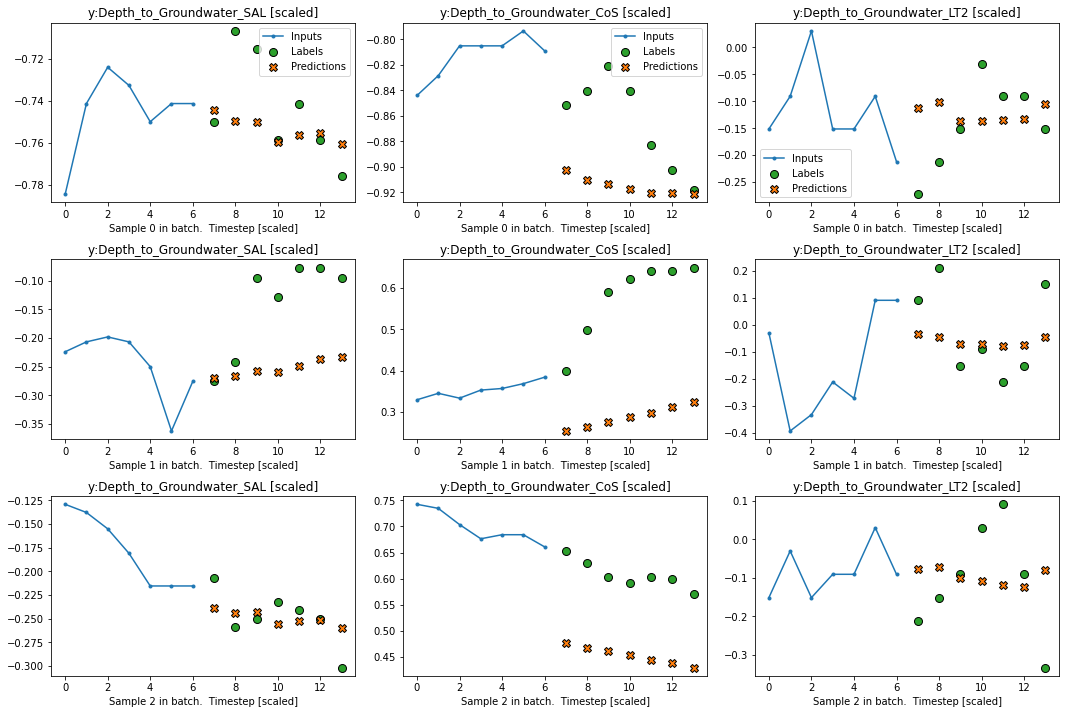

In [369]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*26,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, 26])
])

history = compile_and_fit(multi_lstm_model, multi_window)

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model, targets)

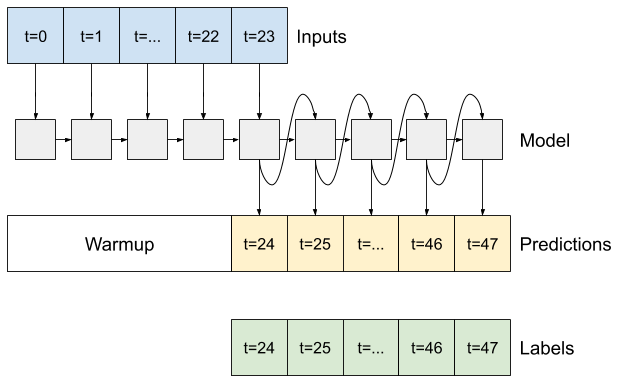

prediction shape after warmup:  (32, 26)
Output shape (batch, time, features):  (32, 7, 26)
Epoch 1/20
48/48 [==============================] - 2s 14ms/step - loss: 0.3803 - mean_absolute_error: 0.5062 - mean_squared_error: 0.3803 - val_loss: 0.0914 - val_mean_absolute_error: 0.2197 - val_mean_squared_error: 0.0914
Epoch 2/20
48/48 [==============================] - 0s 7ms/step - loss: 0.0711 - mean_absolute_error: 0.1907 - mean_squared_error: 0.0711 - val_loss: 0.0607 - val_mean_absolute_error: 0.1670 - val_mean_squared_error: 0.0607
Epoch 3/20
48/48 [==============================] - 0s 7ms/step - loss: 0.0506 - mean_absolute_error: 0.1540 - mean_squared_error: 0.0506 - val_loss: 0.0506 - val_mean_absolute_error: 0.1504 - val_mean_squared_error: 0.0506
Epoch 4/20
48/48 [==============================] - 0s 8ms/step - loss: 0.0416 - mean_absolute_error: 0.1396 - mean_squared_error: 0.0416 - val_loss: 0.0460 - val_mean_absolute_error: 0.1446 - val_mean_squared_error: 0.0460
Epoch 5/20


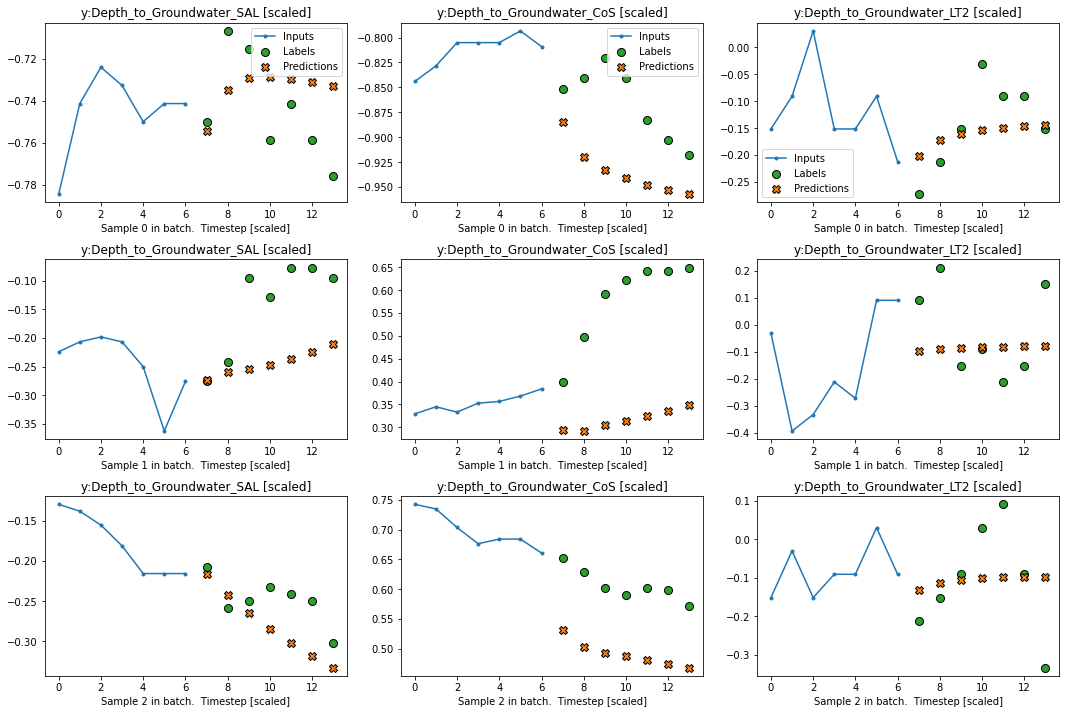

In [376]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps, num_features):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)
    
    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.lstm_rnn(inputs)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state

    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Initialize the lstm state
        prediction, state = self.warmup(inputs)

        # Insert the first prediction
        predictions.append(prediction)

        # Run the rest of the prediction steps
        for n in range(1, self.out_steps):
            # Use the last prediction as input.
            x = prediction
            # Execute one lstm step.
            x, state = self.lstm_cell(x, states=state,
                                      training=training)
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions


feedback_model = FeedBack(units=32, out_steps=OUT_STEPS, num_features=26)
prediction, state = feedback_model.warmup(multi_window.example[0])
print('prediction shape after warmup: ', prediction.shape)
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

history = compile_and_fit(feedback_model, multi_window)

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val, verbose=2)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=2)
multi_window.plot(feedback_model, targets)

Last    : 0.1187
Conv    : 0.1381
LSTM    : 0.1816
AR LSTM : 0.1677


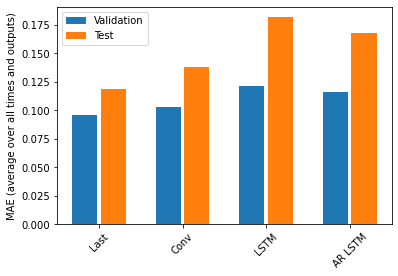

In [375]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

for name, value in multi_performance.items():
    print(f'{name:8s}: {value[1]:0.4f}')

In [ ]:
# # (to be coped with...)
# # prediction backward transformation
# inv_yhat = np.concatenate((X_test.reshape(len(X_test),-1) , yhat.reshape((len(yhat),-1))), axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:,-len(labels):]
# inv_y = np.concatenate((X_test.reshape(len(X_test),-1), y_test.reshape((len(y_test), -1))), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,-len(labels):]
# # model evaluation 
# rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
# print('Test RMSE: %.3f' % rmse)

# References

* [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
* [Cross-batch statefulness- Working with RNNs](https://keras.io/guides/working_with_rnns/)
* [Time Series Forecasting, Tensorflow](https://www.tensorflow.org/tutorials/structured_data/time_series#top_of_page)
* [Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)
* [Multivariate Time Series Forecasting with LSTMs in Keras](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/)
* [(About LSTM Rolling-Predictions) How to Update LSTM Networks During Training for Time Series Forecasting](https://machinelearningmastery.com/update-lstm-networks-training-time-series-forecasting/)
* [How to use Different Batch Sizes when Training and Predicting with LSTMs](https://machinelearningmastery.com/use-different-batch-sizes-training-predicting-python-keras/)
* [Combine LSTM and VAR for Multivariate Time Series Forecasting](https://towardsdatascience.com/combine-lstm-and-var-for-multivariate-time-series-forecasting-abdcb3c7939b)
* [Not yet Read](https://machinelearningmastery.com/suitability-long-short-term-memory-networks-time-series-forecasting/)
* [How to Build VAR model](https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/)